# [Multilevel Modeling](https://en.wikipedia.org/wiki/Multilevel_model)
Idea: Decompose the sum of random numbers into its contributions

for a given set of $x_i$ and $a_{ik}$ with
$$x_i = \Sigma_{j=0}^n \Sigma_{k=1}^{m_j} a_{ik}y_{jk}$$ 
with
* $m_j$ being the number of contributers of layer j
* $y_{jk}$ being the k-th contribution of layer j
* $m_0 = 1$ by default
* $a_{ik} \in \{0, 1\}$
* $\Sigma a_{ik} = 1$ only one contributer per layer

calculate the Distributions $y_{k} \sim N(μ_{k}, σ_{k})$
Boundary conditions:
* $\Sigma _{k} μ_k = 0$ via $μ_{m_j} = -\Sigma_{k = 1}^{m_j-1} μ_{k}$

In [34]:
import numpy as np
#import os
import warnings
import matplotlib.pyplot as plt
import logging
import seaborn as sns
import pymc as pm
import arviz as az
import pytensor as pt
import pytensor #inelegant :-(
#import pandas as pd
#import pymc.sampling_jax as sampling_jax
import nutpie

%matplotlib inline
plt.style.use('default')

#logging.basicConfig(format='%(message)s', level=logging.INFO)
warnings.filterwarnings("ignore", module="scipy")

In [35]:
print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.16.2


## Initialize the data

In [36]:
n_samples = 10000

## setup the individual random generators

In [37]:
def align_coefficients(coefs):
    """ensure that the average over all contributers per level is 0"""
    mem = []
    for level, lcoefs in enumerate(coefs):
        avg = np.mean([m for (m, s) in lcoefs.values()])
        mem.append({k: (m-avg, s) for k, (m,s) in lcoefs.items()})
    
    return mem

def gen_contributer_coefficients(n_contributers, contributer_avg, contributer_sig):
    """creates for n_contributers the average and standard deviation
    Input:
    * n_contributers: list with number of influencers for each level
    * contributer_avg: average for the average of the influencers
    * contributer_sig: average for the stdev for the influencers (lognormal distribution) 
     
    Output:
    Dictionary {level : { influencer: (mu, sigma)}} with the coefficients for every
    influencer in each level
    """
    assert n_contributers[0] == 1, "First level is allowed to have one contributer"
    return align_coefficients([{i : (np.random.normal(contributer_avg), np.random.lognormal(contributer_sig)) for i in range(num)} for lvl, num in enumerate(n_contributers)])

def print_coefficients(contributer_coefficients):
    contributer_coefficients = align_coefficients(contributer_coefficients)
    for m, stage in enumerate(contributer_coefficients):
        for i, (mu, sig) in stage.items():
            print(f"Stage {m}: Contributer {i} mu={mu:.2f}, sig={sig:.2f}")

In [38]:
# easy as a start

cc_12 = [
    {    0 : (0, 5)},
    {    0: (1, 1),
        1: (-1, 1)}
        ]
cc_22 = [
    {    0 : (0, 5)},
    {    0: (1, 1),
        1: (-1, 1)},
    {    0: (1, 1),
        1: (-1, 1)}
        ]
cc_14 = [{    0: (0, 5)},
        {    0: (0, 1),
                1: (0, 1),
                2: (0, 1),
                3: (4, 2)}]
cc_343 = [{    0: (0, 5)},
        {    0: (0, 1),
                1: (0, 1),
                2: (0, 1),
                3: (4, 2)},
            {    0: (0, 1),
                1: (0, 1),
                3: (3, 2)}]

In [39]:
print_coefficients(cc_343)

Stage 0: Contributer 0 mu=0.00, sig=5.00
Stage 1: Contributer 0 mu=-1.00, sig=1.00
Stage 1: Contributer 1 mu=-1.00, sig=1.00
Stage 1: Contributer 2 mu=-1.00, sig=1.00
Stage 1: Contributer 3 mu=3.00, sig=2.00
Stage 2: Contributer 0 mu=-1.00, sig=1.00
Stage 2: Contributer 1 mu=-1.00, sig=1.00
Stage 2: Contributer 3 mu=2.00, sig=2.00


## Create the Data

In [40]:
def gen_data(contributer_coefficients, n_samples):
    """generate random data.
    The first level defines the baseline that holds for all random numbers
    
    Inputs:
    * n_samples: number of samples
    * contributer_coefficients: dictionary with (mean,sig) per level per contributer
    
    Outputs:
    * data: array with the final number
    * contributers: matrix defining the contributers, first column is for the first level"""
    
    assert len(contributer_coefficients[0]) == 1, "Level 0 defines the baseline. It should have exactly one contributer"
    #data = np.random.normal(gen_avg, gen_sig, n_samples)
    data = np.zeros((n_samples, ))
    contributers = np.zeros((n_samples, len(contributer_coefficients)))
    for lvl, cdict in enumerate(contributer_coefficients):
        print(f"creating level {lvl}")
        lvl_influencers = len(cdict) #number of influencers in this level
        lvldata = np.zeros((n_samples, lvl_influencers))

        for i, (mu,sig) in cdict.items():
            lvldata[:,i] = np.random.normal(mu, sig, n_samples)

        selection = np.random.randint(low=0,
                                    high=lvl_influencers,
                                    size=(n_samples))
        contributers[:, lvl] = selection
        
        data += np.array([lvldata[row, col] for row, col in enumerate(selection)])
        # Note: The first level 
    return data, contributers[:, 1:].astype(int)

# Modeling

use [Radon Analysis](https://www.pymc.io/projects/examples/en/latest/generalized_linear_models/multilevel_modeling.html) as reference

In [41]:
def run_model(model, **kwargs):
    print("start compilation")
    compiled_model = nutpie.compile_pymc_model(model)
    print("model is compiled")
    trace = nutpie.sample(
        compiled_model,
        **kwargs
        )
    return trace

In [42]:
def analyze(trace):
    az.summary(trace, round_to=2)
    az.plot_trace(trace,
              compact="true",
    chain_prop={"ls": "-"},)

    
    fig = plt.gcf()
    fig.tight_layout()
    plt.show()

In [43]:
def generate(n_samples, contributer_coefficients):
    if contributer_coefficients == 2:
        n_contributers= len(contributer_coefficients[1])
        print("ATTENTION: just for one level")
    else:
        n_contributers = [len(level) for level in contributer_coefficients][1:]

    data, contributers = gen_data(n_samples=n_samples,
                              contributer_coefficients=contributer_coefficients)

    #contributers = contributers.squeeze(-1) # kill the first level - not needed
    return data, contributers, n_contributers

In [44]:
# generate the data
data0, contributers0, n_contributers0 = generate(n_samples=n_samples, contributer_coefficients=cc_14)
data, contributers, n_contributers = generate(n_samples=n_samples, contributer_coefficients=cc_22)

contributers0 = contributers0.squeeze(-1) # for the 1 level version
n_contributers0 = n_contributers0[0]

creating level 0
creating level 1
creating level 0
creating level 1
creating level 2


In [45]:
with pm.Model() as model0:
    """
    simplest model
    converges for 2 contributers almost for more contributers
    """
    assert type(n_contributers0) is int, "only one level is possible"
    contributer_data_idx = pm.ConstantData("contributer_data_idx", contributers0, dims="obs_id")
    #datam = pm.ConstantData("data_idx", data0, dims="obs_id")

    # Priors
    a_mu = pm.Normal("a_mu", mu=0.0, sigma=10)
    a_sigma = pm.Exponential("a_sigma", 1)

    # contributions
    con_sigmas = pm.Exponential("con_sigmas", 1, shape=n_contributers0)
    cons = pm.Normal("cons", mu=0, sigma = con_sigmas, shape=n_contributers0)

    # expected value
    #y_hat = pm.Deterministic("y_hat", a_mu + cons[contributer_data_idx], dims = "obs_id") #one dimension for every datapoint
    y_hat = a_mu + cons[contributer_data_idx]
    # Data
    value = pm.Normal("value", 
                      mu=y_hat,
                      sigma = a_sigma,
                      observed = data0)

c:\Users\fuerf\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


In [46]:
with pm.Model() as model0b:
    """
    without the baseline a_mu -> works perfectly
    
    """
    assert type(n_contributers0) is int, "only one level is possible"
    contributer_data_idx = pm.ConstantData("contributer_data_idx", contributers0, dims="obs_id")
    #datam = pm.ConstantData("data_idx", data0, dims="obs_id")

    # Priors
    #a_mu = pm.Normal("a_mu", mu=0.0, sigma=10)
    a_sigma = pm.Exponential("a_sigma", 1)

    # contributions
    con_sigmas = pm.Exponential("con_sigmas", 1, shape=n_contributers0)
    cons = pm.Normal("cons", mu=0, sigma = con_sigmas, shape=n_contributers0)

    # expected value
    #y_hat = pm.Deterministic("y_hat", a_mu + cons[contributer_data_idx], dims = "obs_id") #one dimension for every datapoint
    y_hat = cons[contributer_data_idx]
    # Data
    value = pm.Normal("value", 
                      mu=y_hat,
                      sigma = a_sigma,
                      observed = data0)

c:\Users\fuerf\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


In [47]:
n = 5
samples = 10000

In [48]:
def data_faker(n, samples, mu_a=3, sig_a=5, sig_b=1):
    xdata = np.random.normal(mu_a, sig_a, samples)
    bdata = np.random.randint(low=0, high=n, size=(samples))
    mu = np.arange(0, n)-(n-1)/2
    for i,m in enumerate(mu):
        xdata += np.where(bdata == i, np.random.normal(m, sig_b, samples), 0)
    
    return xdata, bdata

In [49]:
xdata, bdata = data_faker(n, samples)

In [50]:
with pm.Model() as model:
    #Input data
    x = pm.Data("x", xdata, dims="obs_id")
    b = pm.Data("b", bdata, dims="obs_id")
    #baseline
    mu_a = pm.Normal("mu_a ", mu=0.0, sigma=10)
    sigma_a= pm.Exponential("sigma_a", 1)
    # level 1
    mu_c = pm.Exponential("mu_c", 1, shape=n)
    sigma_c= pm.Exponential("sigma_c", 1, shape=n)
    c = pm.Normal("c", sigma_c, shape=n)

    y_hat = mu_a + c[b]
    #y_hat = c[b] # --> this one runs stable

    # value
    value = pm.Normal("value", 
                      mu=y_hat,
                      sigma = sigma_a,
                      observed = x)

with pm.Model() as constrained_model:
    #Input data
    x = pm.Data("x", xdata, dims="obs_id")
    b = pm.Data("b", bdata, dims="obs_id")
    
    #baseline
    mu_a = pm.Normal("mu_a ", mu=0.0, sigma=10)
    sigma_a= pm.Exponential("sigma_a", 1)

    # level 1
    mu_c_raw = [pm.Exponential(f"mu_c_raw_{i}", 1) for i in range(n-1)]
    #mu_c = pt.tensor.stacklists(mu_c_raw + [-pt.tensor.sum(mu_c_raw )])
    mu_c = pt.tensor.stacklists(mu_c_raw + [-pt.tensor.sum(pt.tensor.stacklists(mu_c_raw ))])
    sigma_c= pm.Exponential("sigma_c", 1, shape=n)

    c = pm.Normal("c", mu=mu_c, sigma=sigma_c, shape=n)

    y_hat = mu_a + c[b]

    # value
    value = pm.Normal("value", 
                      mu=y_hat,
                      sigma = sigma_a,
                      observed = x)
    
with pm.Model() as constrained_model_rp:
    #Input data
    x = pm.Data("x", xdata, dims="obs_id")
    b = pm.Data("b", bdata, dims="obs_id")
    
    #baseline
    mu_a = pm.Normal("mu_a ", mu=0.0, sigma=10)
    sigma_a= pm.Exponential("sigma_a", 1)

    # level 1
    mu_c_raw = [pm.Exponential(f"mu_c_raw_{i}", 1) for i in range(n-1)]
    mu_c = pt.tensor.stacklists(mu_c_raw + [-pt.tensor.sum(mu_c_raw )])
    # mu_c = pytensor.tensor.stacklists(mu_c_raw + [-pt.tensor.sum(pytensor.tensor.stacklists(mu_c_raw ))])
    sigma_c= pm.Exponential("sigma_c", 1, shape=n)

    # reparametrization
    c_dist = pm.Normal("c_dist", mu=0, sigma=1, shape=n)
    c = pm.Deterministic("c", mu_c + sigma_c * c_dist)

    y_hat = mu_a + c[b]

    # value
    value = pm.Normal("value", 
                      mu=y_hat,
                      sigma = sigma_a,
                      observed = x)

with pm.Model() as constrained_model_rp:
    #Input data
    x = pm.Data("x", xdata, dims="obs_id")
    b = pm.Data("b", bdata, dims="obs_id")
    
    #baseline
    mu_a = pm.Normal("mu_a ", mu=0.0, sigma=10)
    sigma_a= pm.Exponential("sigma_a", 1)

    # level 1
    mu_c_raw = [pm.Exponential(f"mu_c_raw_{i}", 1) for i in range(n-1)]
    mu_c = pt.tensor.stacklists(mu_c_raw + [-pt.tensor.sum(mu_c_raw )])
    # mu_c = pytensor.tensor.stacklists(mu_c_raw + [-pt.tensor.sum(pytensor.tensor.stacklists(mu_c_raw ))])
    sigma_c= pm.Exponential("sigma_c", 1, shape=n)

    # reparametrization
    c_dist = pm.Normal("c_dist", mu=0, sigma=1, shape=n)
    c = pm.Deterministic("c", mu_c + sigma_c * c_dist)

    y_hat = mu_a + c[b]

    # value
    value = pm.Normal("value", 
                      mu=y_hat,
                      sigma = sigma_a,
                      observed = x)

with pm.Model() as constrained_model_rp_det:
    """constrained model with reparametrization,
    trying to define the boundary condition via a deterministic variable (i.e. no c_dist)
    DOES NOT WORK
    """
    #Input data
    x = pm.Data("x", xdata, dims="obs_id")
    b = pm.Data("b", bdata, dims="obs_id")
    
    #baseline
    mu_a = pm.Normal("mu_a ", mu=0.0, sigma=10)
    sigma_a= pm.Exponential("sigma_a", 1)

    # level 1
    mu_c_raw = [pm.Exponential(f"mu_c_raw_{i}", 1) for i in range(n-1)]
    mu_c = pt.tensor.stacklists(mu_c_raw + [-pt.tensor.sum(mu_c_raw )])
    # mu_c = pytensor.tensor.stacklists(mu_c_raw + [-pt.tensor.sum(pytensor.tensor.stacklists(mu_c_raw ))])
    sigma_c= pm.Exponential("sigma_c", 1, shape=n)

    # reparametrization
    c = pm.Deterministic("c", mu_c + sigma_c * pm.Normal("c_dist", mu=0, sigma=1, shape=n))

    y_hat = mu_a + c[b]

    # value
    value = pm.Normal("value", 
                      mu=y_hat,
                      sigma = sigma_a,
                      observed = x)

with pm.Model() as constrained_model_rp_zs:
    """constrained model with reparametrization and zero sum normal distribution"""
    #Input data
    x = pm.Data("x", xdata, dims="obs_id")
    b = pm.Data("b", bdata, dims="obs_id")
    
    #baseline
    mu_a = pm.Normal("mu_a ", mu=0.0, sigma=10)
    sigma_a= pm.Exponential("sigma_a", 1)

    # level 1
    sigma_c= pm.Exponential("sigma_c", 1, shape=n)

    # reparametrization is needed since ZSN has the same sigma for all dimensions
    c_dist = pm.ZeroSumNormal("c_dist", sigma=1, shape=n)
    c = pm.Deterministic("c", sigma_c * c_dist)

    y_hat = mu_a + c[b]

    # value
    value = pm.Normal("value", 
                      mu=y_hat,
                      sigma = sigma_a,
                      observed = x)


start compilation
model is compiled


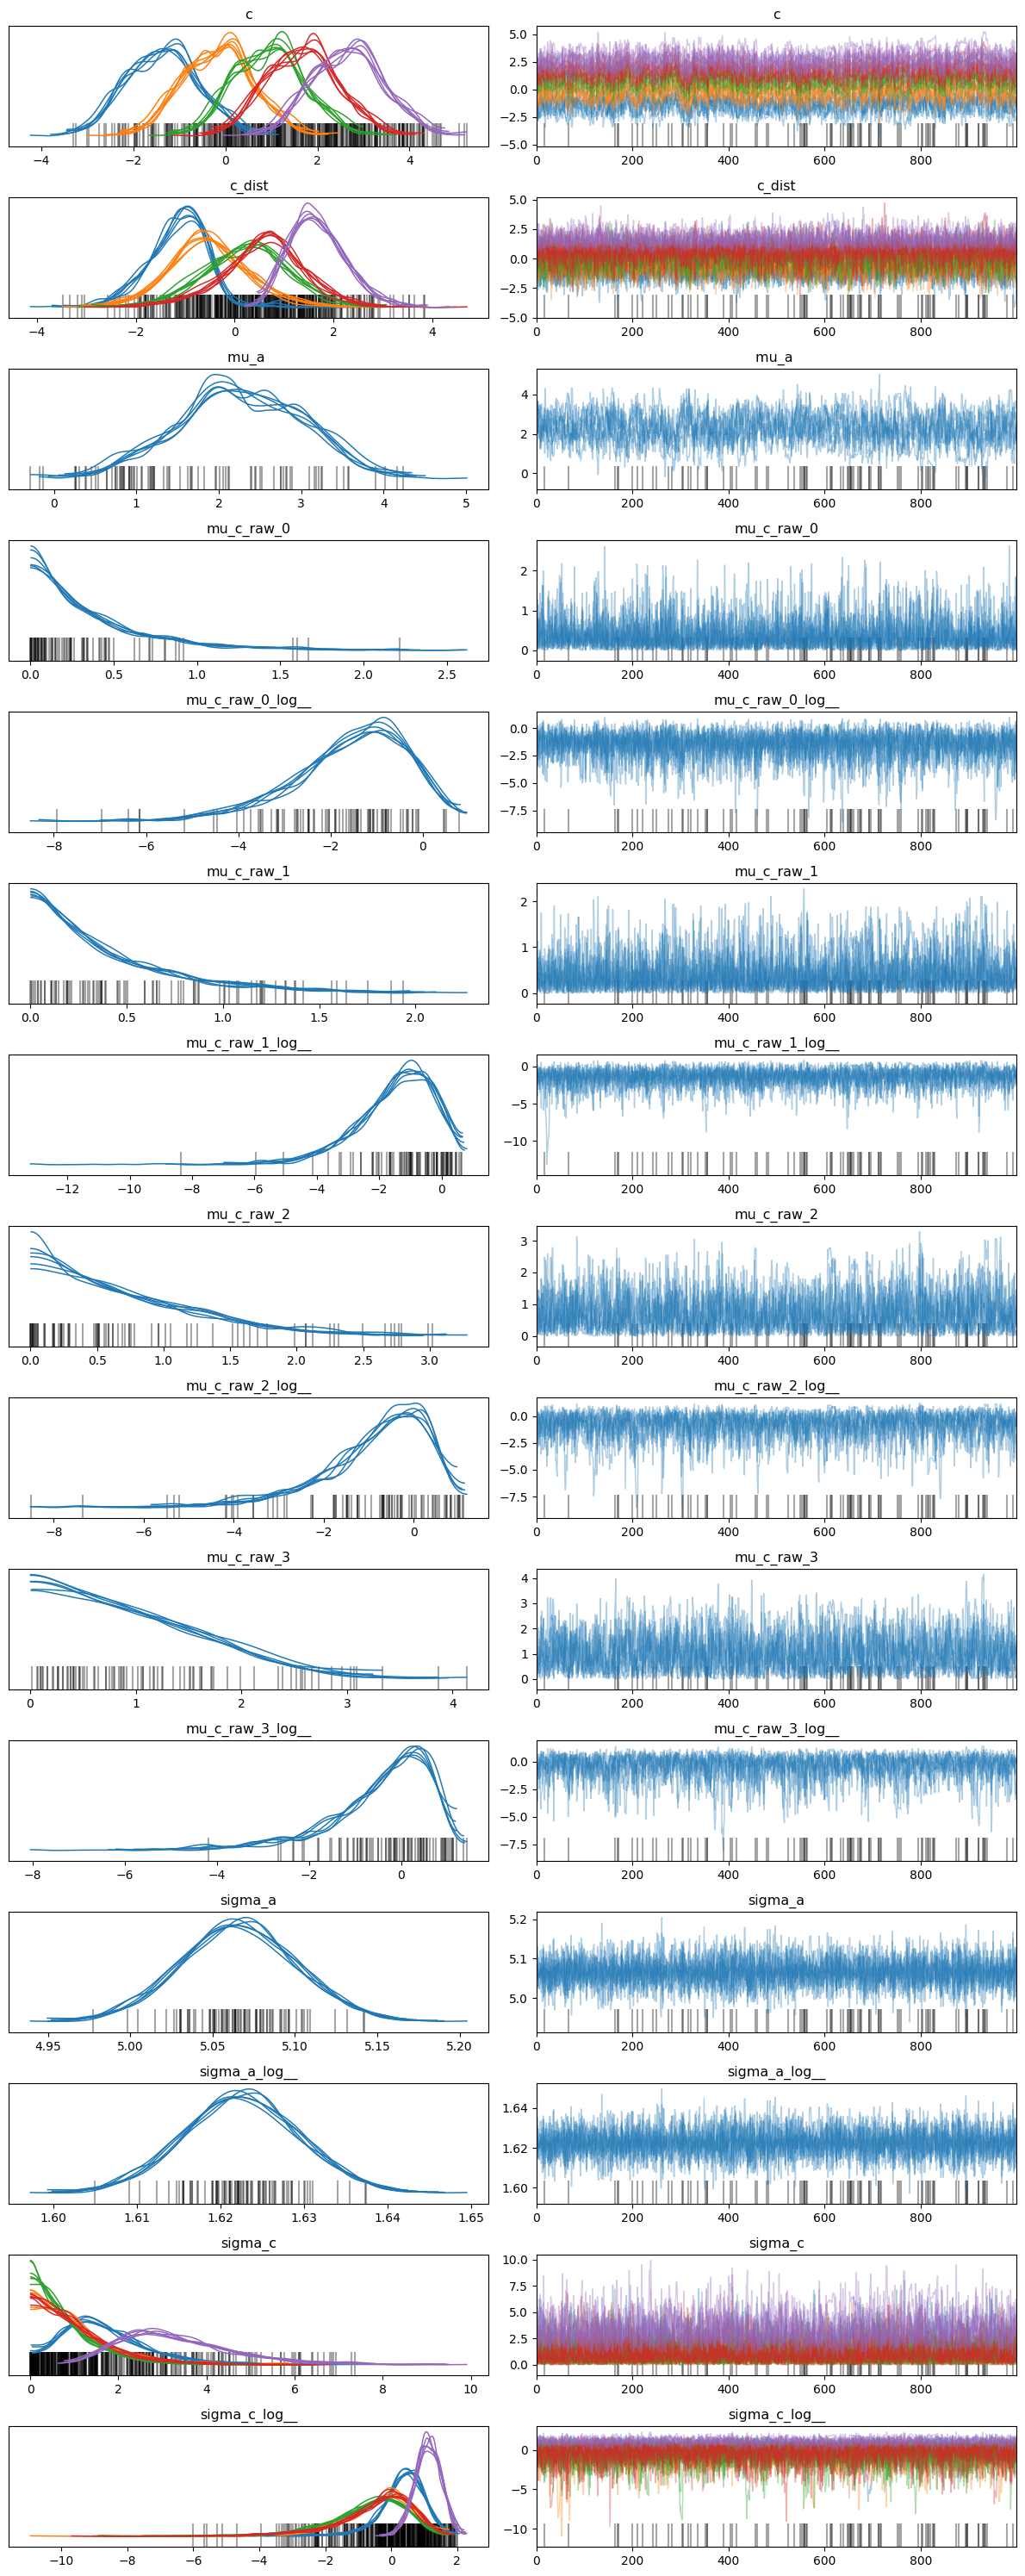

mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
c[0]             -1.36  0.79   -2.71     0.20       0.03     0.02    753.44   
c[1]             -0.16  0.77   -1.56     1.30       0.03     0.02    738.58   
c[2]              0.95  0.77   -0.41     2.43       0.03     0.02    761.50   
c[3]              1.67  0.78    0.32     3.20       0.03     0.02    742.79   
c[4]              2.67  0.78    1.26     4.15       0.03     0.02    748.34   
c_dist[0]        -1.15  0.63   -2.40    -0.16       0.02     0.01   1866.11   
c_dist[1]        -0.52  0.83   -2.09     1.13       0.02     0.01   2082.24   
c_dist[2]         0.24  0.88   -1.38     1.95       0.02     0.01   2532.07   
c_dist[3]         0.59  0.85   -1.08     2.21       0.02     0.01   2800.63   
c_dist[4]         1.68  0.58    0.70     2.79       0.01     0.01   2366.03   
mu_a              2.27  0.77    0.80     3.64       0.03     0.02    735.04   
mu_c_raw_0        0.38  0.38    0.00     1.09       0.01     0.00   3675.90   
mu_c_raw_0_log__ -1.57  1.29   -4.03     0.49       0.02     0.02   3675.90   
mu_c_raw_1        0.41  0.39    0.00     1.17       0.01     0.01   2542.88   
mu_c_raw_1_log__ -1.47  1.28   -3.73     0.57       0.03     0.02   2542.88   
mu_c_raw_2        0.71  0.59    0.00     1.78       0.01     0.01   1669.69   
mu_c_raw_2_log__ -0.84  1.25   -3.17     0.94       0.03     0.02   1669.69   
mu_c_raw_3        1.00  0.73    0.00     2.29       0.02     0.01   1771.36   
mu_c_raw_3_log__ -0.42  1.12   -2.56     1.20       0.03     0.02   1771.36   
sigma_a           5.07  0.04    5.00     5.13       0.00     0.00   6407.97   
sigma_a_log__     1.62  0.01    1.61     1.64       0.00     0.00   6407.97   
sigma_c[0]        1.71  1.03    0.03     3.51       0.02     0.02   1432.13   
sigma_c[1]        1.01  0.89    0.00     2.60       0.02     0.01   2105.34   
sigma_c[2]        0.83  0.77    0.00     2.23       0.01     0.01   3039.25   
sigma_c[3]        1.03  0.89    0.00     2.67       0.02     0.01   2072.80   
sigma_c[4]        3.32  1.34    1.16     5.80       0.03     0.02   1491.68   
sigma_c_log__[0]  0.32  0.77   -1.05     1.53       0.03     0.02   1432.13   
sigma_c_log__[1] -0.46  1.19   -2.54     1.49       0.03     0.02   2105.34   
sigma_c_log__[2] -0.72  1.25   -3.02     1.27       0.02     0.02   3039.25   
sigma_c_log__[3] -0.45  1.20   -2.79     1.42       0.03     0.02   2072.80   
sigma_c_log__[4]  1.12  0.40    0.36     1.86       0.01     0.01   1491.68   

                  ess_tail  r_hat  
c[0]                720.55   1.01  
c[1]                934.39   1.01  
c[2]                716.67   1.01  
c[3]                775.78   1.01  
c[4]                928.44   1.01  
c_dist[0]           877.76   1.01  
c_dist[1]          3301.74   1.00  
c_dist[2]          3194.70   1.00  
c_dist[3]          3478.55   1.00  
c_dist[4]          2365.86   1.00  
mu_a                712.77   1.01  
mu_c_raw_0         2878.22   1.00  
mu_c_raw_0_log__   2878.22   1.00  
mu_c_raw_1         2268.74   1.00  
mu_c_raw_1_log__   2268.74   1.00  
mu_c_raw_2         1682.31   1.00  
mu_c_raw_2_log__   1682.31   1.00  
mu_c_raw_3         1879.39   1.00  
mu_c_raw_3_log__   1879.39   1.00  
sigma_a            3506.80   1.00  
sigma_a_log__      3506.80   1.00  
sigma_c[0]          817.40   1.01  
sigma_c[1]         2314.04   1.00  
sigma_c[2]         2549.63   1.00  
sigma_c[3]         2577.71   1.00  
sigma_c[4]         1498.47   1.00  
sigma_c_log__[0]    817.40   1.01  
sigma_c_log__[1]   2314.04   1.00  
sigma_c_log__[2]   2549.63   1.00  
sigma_c_log__[3]   2577.71   1.00  
sigma_c_log__[4]   1498.47   1.00

In [51]:
trace = run_model(constrained_model_rp_det)
analyze(trace)
az.summary(trace, round_to=2)

# Multi Level Models

In [52]:
n_per_layer = n_contributers
n_layers = len(n_per_layer)
xdata = data
bdata = contributers


In [53]:
bdata.shape

(10000, 2)

In [58]:

with pm.Model(coords={"data"}) as multi_layer_model:
    """constrained model with reparametrization and zero sum normal distribution
    adapted to multiple layers"""
    #Input data
    x = pm.Data("x", xdata, dims="obs_id")
    b = pm.Data("b", bdata, dims=("obs_id", "layer"), shape=(n_samples, n_layers))
    
    #baseline
    mu_a = pm.Normal("mu_a ", mu=0.0, sigma=10)
    sigma_a= pm.Exponential("sigma_a", 1)

    sigma_c= [pm.Exponential(f"sigma_c_{level}", 1, shape=n_level) for level, n_level in enumerate(n_per_layer)]
    c_dist = [pm.ZeroSumNormal(f"c_dist_{level}", sigma=1, shape=n_level) for level, n_level in enumerate(n_per_layer)]
    #c = [pm.Deterministic(f"c_{level}", pt.tensor.dot(sigma_c[level], c_dist[level]))  for level in range(n_layers)]


    c = [pm.Deterministic(f"c_{level}", sigma_c[level]* c_dist[level])  for level in range(n_layers)]
    
    #y_hat = mu_a + pt.tensor.sum(pt.tensor.concatenate(c, axis=1), axis=1)
    """
    y_hat = mu_a + pt.tensor.sum(
        pt.tensor.concatenate(
            [c_[b[:,i]] for i, c_ in enumerate(c)]
            ),
              axis=1
              )
    """
    
    y_hat = mu_a + c[0][b[:,0]]+ c[1][b[:,1]]
    """
    cons = [
        pm.Normal(f"cons_{i}",
                      mu=0,
                      sigma = 1,
                      shape=n_contributers[i]) 
                      for i in range(n_layers)
                      ]

    # expected value
    y_hat = a_mu + pt.tensor.sum(pt.tensor.concatenate([cons[i][b[:,i]] for i in range(n_layers)], axis=1))
    """

    # value
    value = pm.Normal("value", 
                      mu=y_hat,
                      sigma = sigma_a,
                      observed = x)

AttributeError: 'set' object has no attribute 'items'

In [60]:
c

[c_0 ~ Deterministic(f(c_dist_0, sigma_c_0)),
 c_1 ~ Deterministic(f(c_dist_1, sigma_c_1))]

start compilation
model is compiled


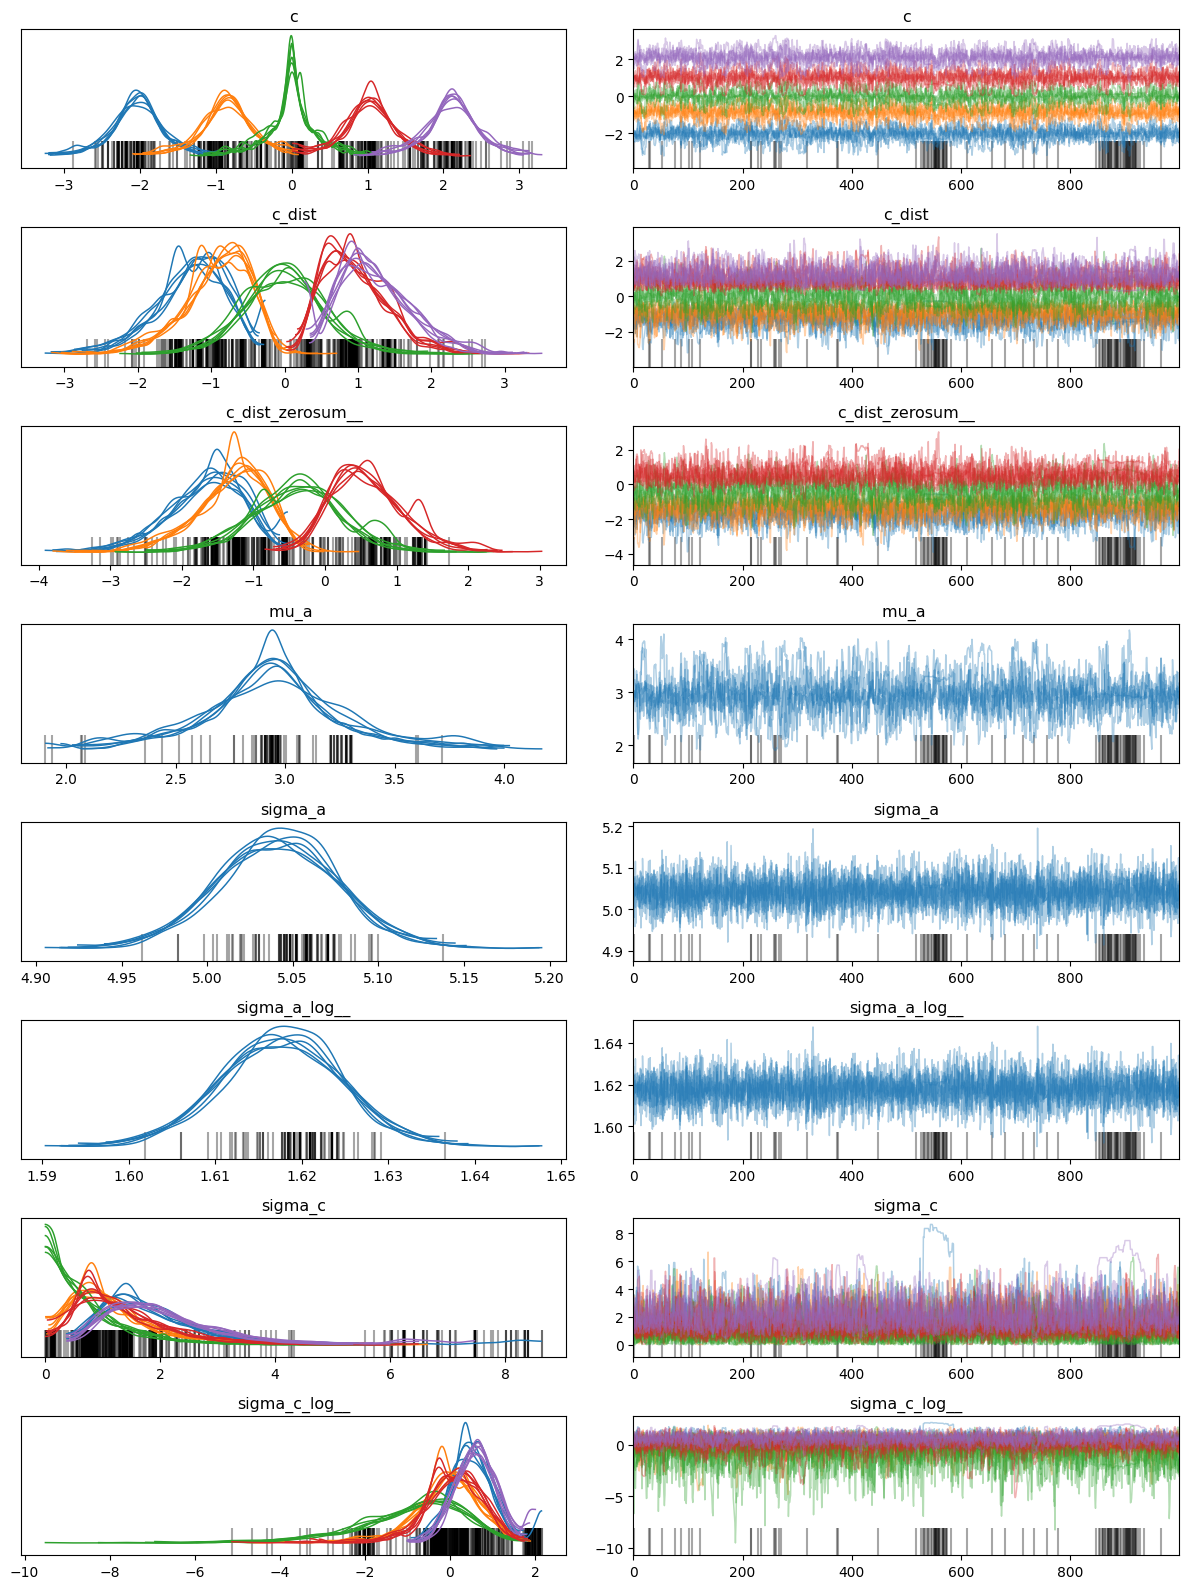

mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
c[0]                -2.04  0.36   -2.74    -1.29       0.01     0.01   
c[1]                -0.86  0.36   -1.54    -0.09       0.01     0.01   
c[2]                -0.01  0.34   -0.68     0.73       0.01     0.01   
c[3]                 1.02  0.36    0.28     1.73       0.01     0.01   
c[4]                 2.11  0.36    1.40     2.86       0.01     0.01   
c_dist[0]           -1.28  0.49   -2.21    -0.42       0.02     0.01   
c_dist[1]           -0.92  0.46   -1.81    -0.18       0.01     0.01   
c_dist[2]            0.00  0.56   -1.04     1.11       0.02     0.01   
c_dist[3]            0.97  0.46    0.22     1.82       0.01     0.01   
c_dist[4]            1.23  0.49    0.31     2.09       0.02     0.01   
c_dist_zerosum__[0] -1.65  0.54   -2.72    -0.74       0.02     0.01   
c_dist_zerosum__[1] -1.30  0.51   -2.29    -0.42       0.01     0.01   
c_dist_zerosum__[2] -0.38  0.63   -1.54     0.89       0.02     0.02   
c_dist_zerosum__[3]  0.59  0.52   -0.27     1.63       0.01     0.01   
mu_a                 2.95  0.34    2.22     3.65       0.01     0.01   
sigma_a              5.04  0.04    4.97     5.11       0.00     0.00   
sigma_a_log__        1.62  0.01    1.60     1.63       0.00     0.00   
sigma_c[0]           1.92  1.07    0.52     3.72       0.07     0.07   
sigma_c[1]           1.20  0.83    0.01     2.77       0.02     0.01   
sigma_c[2]           0.74  0.76    0.00     2.08       0.02     0.01   
sigma_c[3]           1.35  0.88    0.02     2.95       0.02     0.01   
sigma_c[4]           2.08  1.10    0.52     4.00       0.07     0.06   
sigma_c_log__[0]     0.53  0.49   -0.40     1.45       0.02     0.02   
sigma_c_log__[1]    -0.07  0.77   -1.42     1.34       0.02     0.02   
sigma_c_log__[2]    -0.90  1.32   -3.35     1.27       0.03     0.02   
sigma_c_log__[3]     0.08  0.72   -1.20     1.39       0.02     0.02   
sigma_c_log__[4]     0.61  0.49   -0.29     1.56       0.02     0.02   

                     ess_bulk  ess_tail  r_hat  
c[0]                   848.27    901.09   1.01  
c[1]                   860.86    878.17   1.01  
c[2]                   765.41    879.17   1.01  
c[3]                   837.96    880.42   1.01  
c[4]                   909.97    899.66   1.01  
c_dist[0]              808.88    533.14   1.01  
c_dist[1]             2153.93   2208.57   1.00  
c_dist[2]              899.55   2095.26   1.01  
c_dist[3]             1725.14   1451.86   1.01  
c_dist[4]              595.13    228.38   1.01  
c_dist_zerosum__[0]    839.55    520.63   1.00  
c_dist_zerosum__[1]   2190.00   1816.38   1.01  
c_dist_zerosum__[2]    828.38    518.53   1.01  
c_dist_zerosum__[3]   1437.02   1448.15   1.01  
mu_a                   816.54    821.55   1.01  
sigma_a               6596.90   3640.53   1.00  
sigma_a_log__         6596.90   3640.53   1.01  
sigma_c[0]             678.11    513.26   1.01  
sigma_c[1]            1470.31   1491.98   1.01  
sigma_c[2]            1849.16   2540.32   1.00  
sigma_c[3]            1279.08    980.70   1.00  
sigma_c[4]             567.95    230.68   1.01  
sigma_c_log__[0]       678.11    513.26   1.01  
sigma_c_log__[1]      1470.31   1491.98   1.01  
sigma_c_log__[2]      1849.16   2540.32   1.00  
sigma_c_log__[3]      1279.08    980.70   1.00  
sigma_c_log__[4]       567.95    230.68   1.01

In [36]:
trace = run_model(constrained_model_rp_zs)
analyze(trace)
az.summary(trace, round_to=2)

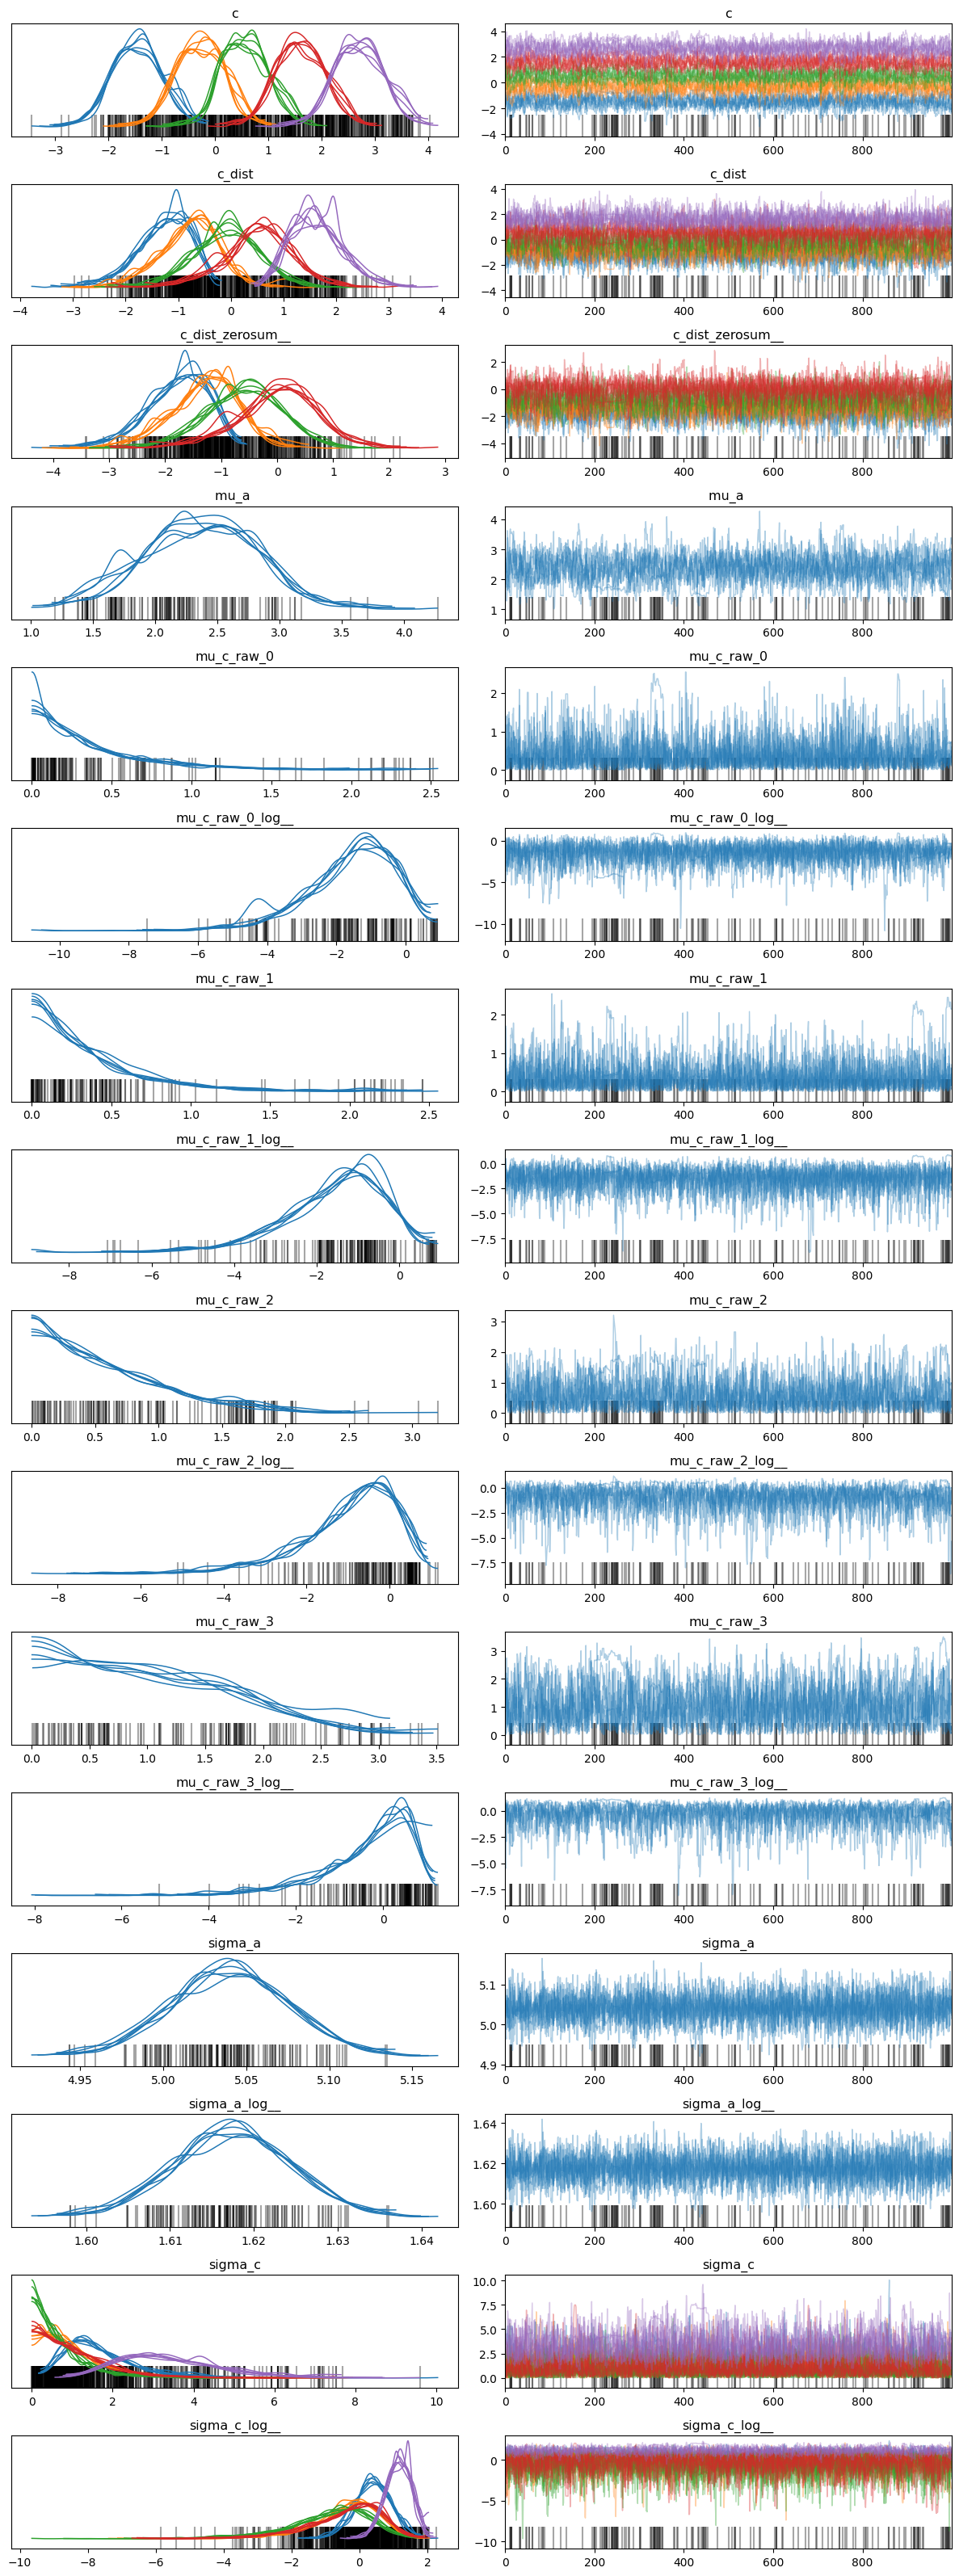

mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
c[0]                -1.46  0.48   -2.30    -0.54       0.01     0.01   
c[1]                -0.28  0.47   -1.10     0.62       0.01     0.01   
c[2]                 0.56  0.46   -0.21     1.47       0.01     0.01   
c[3]                 1.60  0.47    0.77     2.50       0.01     0.01   
c[4]                 2.70  0.48    1.83     3.60       0.02     0.01   
c_dist[0]           -1.28  0.52   -2.25    -0.39       0.01     0.01   
c_dist[1]           -0.78  0.58   -1.92     0.27       0.02     0.01   
c_dist[2]           -0.09  0.64   -1.28     1.15       0.01     0.01   
c_dist[3]            0.51  0.69   -0.88     1.75       0.02     0.01   
c_dist[4]            1.64  0.51    0.70     2.56       0.01     0.01   
c_dist_zerosum__[0] -1.78  0.57   -2.82    -0.78       0.01     0.01   
c_dist_zerosum__[1] -1.28  0.63   -2.48    -0.08       0.02     0.01   
c_dist_zerosum__[2] -0.60  0.70   -1.86     0.77       0.01     0.01   
c_dist_zerosum__[3]  0.00  0.75   -1.46     1.43       0.02     0.02   
mu_a                 2.37  0.46    1.43     3.15       0.01     0.01   
mu_c_raw_0           0.38  0.40    0.00     1.12       0.01     0.01   
mu_c_raw_0_log__    -1.57  1.31   -4.13     0.54       0.03     0.03   
mu_c_raw_1           0.38  0.38    0.00     1.04       0.01     0.01   
mu_c_raw_1_log__    -1.55  1.25   -3.99     0.44       0.03     0.02   
mu_c_raw_2           0.61  0.50    0.00     1.58       0.02     0.01   
mu_c_raw_2_log__    -1.00  1.24   -3.33     0.80       0.03     0.02   
mu_c_raw_3           1.06  0.74    0.00     2.35       0.03     0.02   
mu_c_raw_3_log__    -0.33  1.10   -2.31     1.19       0.03     0.02   
sigma_a              5.04  0.04    4.97     5.11       0.00     0.00   
sigma_a_log__        1.62  0.01    1.60     1.63       0.00     0.00   
sigma_c[0]           1.71  0.95    0.30     3.49       0.03     0.02   
sigma_c[1]           0.99  0.81    0.00     2.40       0.02     0.01   
sigma_c[2]           0.72  0.71    0.00     1.97       0.01     0.01   
sigma_c[3]           1.05  0.93    0.00     2.61       0.02     0.01   
sigma_c[4]           3.39  1.29    1.26     5.87       0.04     0.03   
sigma_c_log__[0]     0.39  0.55   -0.64     1.41       0.02     0.01   
sigma_c_log__[1]    -0.41  1.05   -2.30     1.41       0.03     0.02   
sigma_c_log__[2]    -0.90  1.27   -3.28     1.20       0.02     0.02   
sigma_c_log__[3]    -0.44  1.18   -2.66     1.42       0.03     0.02   
sigma_c_log__[4]     1.15  0.39    0.40     1.84       0.01     0.01   

                     ess_bulk  ess_tail  r_hat  
c[0]                  1042.13    863.24   1.01  
c[1]                  1031.27   1390.04   1.01  
c[2]                   975.40    821.73   1.01  
c[3]                  1061.30   1417.96   1.01  
c[4]                   997.92   1254.50   1.01  
c_dist[0]             2289.70   2625.81   1.00  
c_dist[1]             1180.57    658.48   1.00  
c_dist[2]             1917.08   2409.15   1.01  
c_dist[3]             1303.40   1357.13   1.01  
c_dist[4]             2608.55   2920.39   1.01  
c_dist_zerosum__[0]   2266.72   2666.51   1.01  
c_dist_zerosum__[1]   1289.26    561.03   1.00  
c_dist_zerosum__[2]   2199.75   2752.05   1.00  
c_dist_zerosum__[3]   1293.34   1511.58   1.01  
mu_a                   990.14    827.14   1.01  
mu_c_raw_0            1565.91    578.03   1.00  
mu_c_raw_0_log__      1565.91    578.03   1.00  
mu_c_raw_1            2006.51   1120.75   1.00  
mu_c_raw_1_log__      2006.51   1120.75   1.00  
mu_c_raw_2            1096.38    841.73   1.00  
mu_c_raw_2_log__      1096.38    841.73   1.00  
mu_c_raw_3             824.51    331.97   1.01  
mu_c_raw_3_log__       824.51    331.97   1.01  
sigma_a               3082.36   2609.40   1.00  
sigma_a_log__         3082.36   2609.40   1.00  
sigma_c[0]            1136.80   1068.48   1.00  
sigma_c[1]            1826.80   2181.76   1.00  
sigma_c[2]            3376.66   2883.46   1.00  
sigma_c

In [27]:
analyze(trace)
az.summary(trace, round_to=2)

# First Try

In [92]:
with pm.Model() as model0c:
    """
    set the cons to 0
    
    """
    assert type(n_contributers0) is int, "only one level is possible"
    contributer_data_idx = pm.ConstantData("contributer_data_idx", contributers0, dims="obs_id")
    #datam = pm.ConstantData("data_idx", data0, dims="obs_id")

    # Priors
    a_mu = pm.Normal("a_mu", mu=0.0, sigma=10)
    a_sigma = pm.Exponential("a_sigma", 1)

    # contributions
    con_sigmas = pm.Exponential("con_sigmas", 1, shape=n_contributers0)
    #cons_raw = pm.Normal("cons", mu=0, sigma = con_sigmas, shape=n_contributers0-1)
    cons_raw = [pm.Normal(f"cons_{i}", mu=0, sigma = con_sigmas, shape=1) for i in range(n_contributers0-1)]
    """
    cons = [ -pt.sum(cons_raw, axis=0)
            if i == n_contributers0 else cons_raw[i]
            for i in range(n_contributers0)
            ]"""
    #cr = [cons_raw[i] for i in range(n_contributers0-1)]+[-pt.tensor.sum(cons_raw, axis=0)]
    #cons = pytensor.tensor.stacklists([cons_raw, -pt.tensor.sum(cons_raw, axis=0)]) # they need to have the same dimensions
    #cons = pytensor.tensor.stacklists(cons_raw +[-pt.tensor.sum(cons_raw)])
    cons = pytensor.tensor.stacklists(cons_raw +[-pt.tensor.sum(pytensor.tensor.stacklists(cons_raw))])
    

    # expected value
    #y_hat = pm.Deterministic("y_hat", a_mu + cons[contributer_data_idx], dims = "obs_id") #one dimension for every datapoint
    y_hat = cons[contributer_data_idx]
    # Data
    value = pm.Normal("value", 
                      mu=y_hat,
                      sigma = a_sigma,
                      observed = data0)

c:\Users\fuerf\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


TypeError: Only tensors with the same number of dimensions can be joined. Input ndims were: [2, 2, 2, 1].

In [10]:
with pm.Model() as model1:
    """split sigmas via dirichlet distribution
    --> does not converge"""
    assert type(n_contributers0) is int, "only one level is possible"
    contributer_data_idx = pm.Data("contributer_data_idx", contributers0, dims="obs_id")
    #datam = pm.ConstantData("data_idx", data0, dims="obs_id")

    # Priors
    a_mu = pm.Normal("a_mu", mu=0.0, sigma=10)
    a_sigma = pm.Exponential("a_sigma", 1)

    # contributions
    con_sigmas = pm.Exponential("con_sigmas", 1, shape=n_contributers0)
    con_mu = pm.Dirichlet("con_mu_raw",1/n_contributers0 * pm.math.ones(n_contributers0), shape=n_contributers0) # Dirichlet allows only positive numbers --> factor is needed
    conf_factor = pm.Exponential("factor", 1)

    con_mu = pm.Deterministic("con_mu", conf_factor* con_mu)

    cons = pm.Normal("cons", mu=con_mu, sigma = con_sigmas, shape=n_contributers0)

    # expected value
    #y_hat = pm.Deterministic("y_hat", a_mu + cons[contributer_data_idx]) #one dimension for every datapoint
    y_hat = a_mu + cons[contributer_data_idx]
    # Data
    value = pm.Normal("value", 
                      mu=y_hat,
                      sigma = a_sigma,
                      observed = data0)

In [39]:
trace = run_model(model0c)
analyze(trace)

start compilation


ValueError: Alloc static input type and target shape are incompatible: Vector(int8, shape=(4,)) vs (3,)

mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
a_sigma              5.17  0.02    5.13     5.21       0.00     0.00   
a_sigma_log__        1.64  0.00    1.64     1.65       0.00     0.00   
con_sigmas[0]        0.40  0.51    0.00     1.32       0.01     0.01   
con_sigmas[1]        0.43  0.53    0.01     1.35       0.01     0.01   
con_sigmas[2]        0.39  0.53    0.00     1.33       0.01     0.01   
con_sigmas[3]        2.87  1.09    1.23     4.80       0.02     0.02   
con_sigmas_log__[0] -1.61  1.27   -3.90     0.80       0.04     0.03   
con_sigmas_log__[1] -1.46  1.19   -3.53     0.96       0.04     0.03   
con_sigmas_log__[2] -1.71  1.33   -4.17     0.82       0.04     0.03   
con_sigmas_log__[3]  0.99  0.35    0.35     1.64       0.01     0.01   
cons[0]              0.06  0.06   -0.03     0.18       0.00     0.00   
cons[1]              0.09  0.06   -0.02     0.19       0.00     0.00   
cons[2]             -0.05  0.06   -0.16     0.05       0.00     0.00   
cons[3]              4.05  0.06    3.94     4.16       0.00     0.00   

                     ess_bulk  ess_tail  r_hat  
a_sigma               3082.05   2417.06    1.0  
a_sigma_log__         3082.05   2417.06    1.0  
con_sigmas[0]         1420.64    790.22    1.0  
con_sigmas[1]         1137.42    661.23    1.0  
con_sigmas[2]         1391.47    784.49    1.0  
con_sigmas[3]         2522.42   2910.38    1.0  
con_sigmas_log__[0]   1420.64    790.22    1.0  
con_sigmas_log__[1]   1137.42    661.23    1.0  
con_sigmas_log__[2]   1391.47    784.49    1.0  
con_sigmas_log__[3]   2522.42   2910.38    1.0  
cons[0]               2323.70   2788.08    1.0  
cons[1]               2549.54   2269.34    1.0  
cons[2]               2499.60   2602.07    1.0  
cons[3]               4051.75   3572.03    1.0

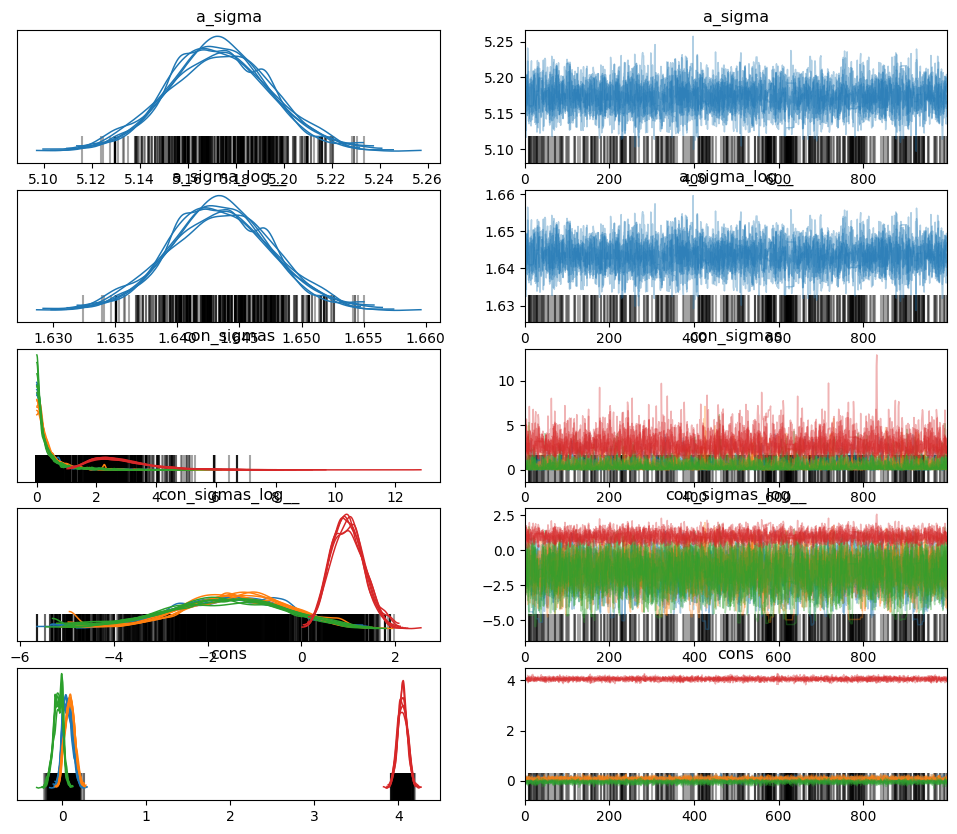

In [25]:
analyze(trace)

In [26]:
def get_dir(n):
    """return initializing value for dirichlet -> all values are 1/n as pytensor"""
    #return 1/n * np.ones(n)
    return 1/(n) * pm.math.ones(n) #maybe this can be optimized

In [84]:


with pm.Model() as model2:
    """
    Idea:
    * calculate sigma of the data
    * distribute it via the sums to all individual contributions
    """
    assert type(n_contributers) is int, "only one level is possible"
    contributer_data_idx = pm.Data("contributer_data_idx", contributers0, dims="obs_id")
    sigmax = pm.Data("sigmax", np.std(data0))

    # Priors
    a_mu = pm.Normal("a_mu", mu=0.0, sigma=10)
    sigmas = pm.Dirichlet("sigmas",get_dir(n_contributers+1), shape=n_contributers+1)

    # contributions
    con_mu = pm.Dirichlet("con_mu_raw",get_dir(n_contributers), shape=n_contributers) # Dirichlet allows only positive numbers --> factor is needed
    conf_factor = pm.Exponential("factor", 1)

    con_mu = pm.Deterministic("con_mu", conf_factor* con_mu)

    cons = pm.Normal("cons", mu=con_mu, sigma = sigmas[1:]**0.5, shape=n_contributers)

    # expected value
    y_hat = a_mu + cons[contributer_data_idx]

    # Data
    value = pm.Normal("value", 
                      mu=y_hat,
                      sigma = sigmas[0]**0.5,
                      observed = data0)

In [25]:
# Sigmas will be one big vector for all contributors.
# Therefore, indexing is needed to find the right values

def start(n_contributers, level):
    assert 0 <= level < len(n_contributers), f"level {level} not possible for {n_contributers}"
    return int(1 + np.sum(n_contributers[:level]))

def end(n_contributers, level):
    assert 0 <= level < len(n_contributers), f"level {level} not possible for {n_contributers}"
    return int(1 + np.sum(n_contributers[:(level+1)]))
    

In [29]:
n_cons = int(1+np.sum(n_contributers))
n_level = len(n_contributers)

In [30]:
with pm.Model() as mlmodel1:
    """
    multi-level model
    Idea:
    * calculate sigma of the data
    * distribute it via the sums to all individual contributions
    """
    assert type(n_contributers) is list, "only multi-levels are possible"

    contributer_data_idx = pm.Data("contributer_data_idx", 
                                   contributers, 
                                   dims=("obs_id", "level"), 
                                   shape= (n_samples, n_level))
    
    data_idx = pm.Data("data_idx", 
                       data,
                       dims="obs_id",)
                       #shape=n_samples)
    
    sigmax = pm.Data("sigmax", np.std(data))

    # Priors
    a_mu = pm.Normal("a_mu", mu=0.0, sigma=10)
    sigmas_raw = pm.Dirichlet("sigmas_raw", get_dir(n_cons), shape=n_cons)
    sigmas = pm.Deterministic("sigmas", sigmax*sigmas_raw)

    # contributions
    #con_mu = pm.Dirichlet("con_mu_raw",get_dir(n_contributers), shape=n_contributers) # Dirichlet allows only positive numbers --> factor is needed
    con_mu_dir = [pm.Dirichlet(f"con_mu_raw_{i}",get_dir(n_cons), shape=n_cons) for i, n_cons in enumerate(n_contributers)]
    
    con_factor = pm.Exponential("factor", 1, shape=n_level)

    con_mu = [pm.Deterministic(f"con_mu_{i}", con_factor[i]* con_mu_dir[i]) for i in range(n_level)]

    cons = [
        pm.Normal(f"cons_{i}",
                      mu=con_mu[i],
                      sigma = sigmas[start(n_contributers, i):end(n_contributers, i)]**0.5,
                      shape=n_contributers) 
                      for i in range(n_level)
                      ]

    # expected value
    y_hat = a_mu + pt.tensor.sum(pt.tensor.concatenate([cons[i][contributer_data_idx[:,i]] for i in range(n_level)], axis=1))

    # Data
    value = pm.Normal("value", 
                      mu=y_hat,
                      sigma = sigmas[0]**0.5,
                      observed = data_idx)

try a [reparametrization](https://twiecki.io/blog/2017/02/08/bayesian-hierchical-non-centered/) via
```
    # Before:
    # a = pm.Normal('a', mu=mu_a, sd=sigma_a, shape=n_counties)
    # Transformed:
    a_offset = pm.Normal('a_offset', mu=0, sd=1, shape=n_counties)
    a = pm.Deterministic("a", mu_a + a_offset * sigma_a)
```


In [23]:
n_level = n_layers
n_cons

In [27]:
with pm.Model() as mlmodel2:
    """
    multi-level model
    Idea:
    * calculate sigma of the data
    * distribute it via the sums to all individual contributions

    # Before:
    # a = pm.Normal('a', mu=mu_a, sd=sigma_a, shape=n_counties)
    # Transformed:
    a_offset = pm.Normal('a_offset', mu=0, sd=1, shape=n_counties)
    a = pm.Deterministic("a", mu_a + a_offset * sigma_a)
    """
    assert type(n_contributers) is list, "only multi-levels are possible"

    contributer_data_idx = pm.Data("contributer_data_idx", 
                                   contributers, 
                                   dims=("obs_id", "level"), 
                                   shape= (n_samples, n_level))
    
    data_idx = pm.Data("data_idx", 
                       data,
                       dims="obs_id",)
                       #shape=n_samples)
    
    sigmax = pm.Data("sigmax", np.std(data))

    # Priors
    a_mu = pm.Normal("a_mu", mu=0.0, sigma=10)
    sigmas_raw = pm.Dirichlet("sigmas_raw", get_dir(n_cons), shape=n_cons)
    sigmas = pm.Deterministic("sigmas", sigmax*sigmas_raw)

    # contributions
    #con_mu = pm.Dirichlet("con_mu_raw",get_dir(n_contributers), shape=n_contributers) # Dirichlet allows only positive numbers --> factor is needed
    con_mu_dir = [pm.Dirichlet(f"con_mu_dir_{i}",get_dir(n_cons), shape=n_cons) for i, n_cons in enumerate(n_contributers)]
    
    con_factor = pm.Exponential("factor", 1, shape=n_level)

    con_mu = [pm.Deterministic(f"con_mu_{i}", con_factor[i]* con_mu_dir[i]) for i in range(n_level)]
    """
    cons = [
        pm.Normal(f"cons_{i}",
                      mu=con_mu[i],
                      sigma = sigmas[start(n_contributers, i):end(n_contributers, i)]**0.5,
                      shape=n_contributers) 
                      for i in range(n_level)
                      ]
    """
    # reparametrization
    cons_offset = [
        pm.Normal(f"cons_offset_{i}",
                      mu=0,
                      sigma = 1,
                      shape=n_contributers) 
                      for i in range(n_level)
                      ]
    cons = [
        pm.Deterministic(f"cons_{i}",
                         con_mu[i] + cons_offset[i] * sigmas[start(n_contributers, i):end(n_contributers, i)]**0.5)
                         for i in range(n_level)
                         ]
    # expected value
    y_hat = a_mu + pt.tensor.sum(pt.tensor.concatenate([cons[i][contributer_data_idx[:,i]] for i in range(n_level)], axis=1))

    # Data
    value = pm.Normal("value", 
                      mu=y_hat,
                      sigma = sigmas[0]**0.5,
                      observed = data_idx)

NameError: name 'n_cons' is not defined

[Profiling](https://www.pymc.io/projects/examples/en/latest/howto/profiling.html)

In [47]:
bdata

array([3, 2, 2, ..., 1, 4, 2])

In [199]:
mlmodel2.profile(mlmodel2.logp()).summary()

Function profiling
  Message: c:\Users\fuerf\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\pytensorf.py:1039
  Time in 1000 calls to Function.__call__: 5.761102e+02s
  Time in Function.vm.__call__: 576.0453123999432s (99.989%)
  Time in thunks: 575.9412937998313s (99.971%)
  Total compilation time: 4.372608e-01s
    Number of Apply nodes: 106
    PyTensor rewrite time: 4.296800e-01s
       PyTensor validate time: 8.765600e-03s
    PyTensor Linker time (includes C, CUDA code generation/compiling): 0.0028562000006786548s
       C-cache preloading 0.000000e+00s
       Import time 0.000000e+00s
       Node make_thunk time 1.238600e-03s
           Node Composite{...}(Sum{axes=None}.0, Max{axes=None}.0, 2.0, Max{axes=None}.0, Sum{axes=None}.0, 5.0, Max{axes=None}.0, Sum{axes=None}.0, -0.22579138462016424, Sum{axes=None}.0, Sum{axes=None}.0, Sum{axes=None}.0, Sum{axes=None}.0, DropDims{axis=0}.0, -inf, Sum{axes=None}.0, Any{axis=0}.0, Any{axis=0}.0, DropDims{axis=0}.0, Sum{ax

Next idea: go back to the initial approach with n-1 dimensions via
```
cons_raw = pm.Normal("cons_raw", 0, 1, shape=n-1)
cons = [
    -pt.tensor.sum(pt.tensor.concatenate(cons_raw)) if i == n-1 else
        pm.Deterministic(f"cons{i}", cons_raw[i])
    for i in range(n)
]
```
Loop fusion failes???

https://discourse.pymc.io/t/panel-model-fitting-issue/9147

In [198]:
print("start compilation")
compiled_model = nutpie.compile_pymc_model(mlmodel2)
print("model is compiled")
trace_nutpie = nutpie.sample(
    compiled_model,
    tune=1000,
    draws=4000,
    chains=12,
    )

start compilation


c:\Users\fuerf\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytensor\tensor\rewriting\elemwise.py:1027: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(


model is compiled


In [194]:
az.summary(trace_nutpie, round_to=2)

mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
a_mu                     -0.11  0.02   -0.16    -0.06       0.00     0.00   
con_mu[0]                 0.01  0.01    0.00     0.04       0.00     0.00   
con_mu[1]                 0.20  0.03    0.15     0.26       0.00     0.00   
con_mu[2]                 0.18  0.03    0.12     0.24       0.00     0.00   
con_mu[3]                 4.07  0.03    4.01     4.13       0.00     0.00   
con_mu_raw[0]             0.00  0.00    0.00     0.01       0.00     0.00   
con_mu_raw[1]             0.05  0.01    0.03     0.06       0.00     0.00   
con_mu_raw[2]             0.04  0.01    0.03     0.05       0.00     0.00   
con_mu_raw[3]             0.91  0.01    0.88     0.93       0.00     0.00   
con_mu_raw_simplex__[0]  -4.72  2.33   -8.88    -1.69       0.49     0.35   
con_mu_raw_simplex__[1]   0.63  0.77   -0.36     2.03       0.16     0.11   
con_mu_raw_simplex__[2]   0.47  0.76   -0.50     1.91       0.16     0.11   
cons[0]                   0.01  0.01   -0.00     0.04       0.00     0.00   
cons[1]                   0.20  0.03    0.15     0.26       0.00     0.00   
cons[2]                   0.18  0.03    0.12     0.24       0.00     0.00   
cons[3]                   4.07  0.03    4.01     4.13       0.00     0.00   
factor                    4.46  0.09    4.29     4.64       0.01     0.01   
factor_log__              1.49  0.02    1.46     1.53       0.00     0.00   
sigmas[0]                 1.00  0.00    1.00     1.00       0.00     0.00   
sigmas[1]                 0.00  0.00    0.00     0.00       0.00     0.00   
sigmas[2]                 0.00  0.00    0.00     0.00       0.00     0.00   
sigmas[3]                 0.00  0.00    0.00     0.00       0.00     0.00   
sigmas[4]                 0.00  0.00    0.00     0.00       0.00     0.00   
sigmas_simplex__[0]      12.10  0.98   10.21    13.74       0.09     0.06   
sigmas_simplex__[1]      -3.69  2.91   -9.08     1.64       0.34     0.24   
sigmas_simplex__[2]      -3.25  2.36   -8.13     0.22       0.37     0.32   
sigmas_simplex__[3]      -2.93  2.10   -7.24     0.38       0.28     0.24   

                         ess_bulk  ess_tail  r_hat  
a_mu                        77.41     84.00   1.10  
con_mu[0]                   22.83     65.42   1.51  
con_mu[1]                  116.04    305.22   1.10  
con_mu[2]                  102.49    109.21   1.08  
con_mu[3]                   93.51    118.32   1.08  
con_mu_raw[0]               22.82     65.42   1.51  
con_mu_raw[1]              128.15    746.65   1.09  
con_mu_raw[2]              108.57    130.81   1.07  
con_mu_raw[3]               69.30     73.68   1.11  
con_mu_raw_simplex__[0]     22.81     63.83   1.51  
con_mu_raw_simplex__[1]     23.59     88.85   1.48  
con_mu_raw_simplex__[2]     22.86     56.18   1.51  
cons[0]                     23.21     18.28   1.48  
cons[1]                    115.28    297.63   1.10  
cons[2]                    102.80    109.63   1.08  
cons[3]                     95.07    118.17   1.08  
factor                      76.74     75.94   1.16  
factor_log__                76.74     75.94   1.16  
sigmas[0]                  182.78   1526.60   1.04  
sigmas[1]                   89.91    147.06   1.08  
sigmas[2]                   44.14     18.52   1.18  
sigmas[3]                   55.07     21.07   1.14  
sigmas[4]                  403.97    190.56   1.05  
sigmas_simplex__[0]        131.06    836.48   1.06  
sigmas_simplex__[1]         52.85     18.27   1.15  
sigmas_simplex__[2]         45.37     28.63   1.19  
sigmas_simplex__[3]         65.13     30.33   1.13

array([[<Axes: title={'center': 'a_mu'}>,
        <Axes: title={'center': 'a_mu'}>],
       [<Axes: title={'center': 'con_mu'}>,
        <Axes: title={'center': 'con_mu'}>],
       [<Axes: title={'center': 'con_mu_raw'}>,
        <Axes: title={'center': 'con_mu_raw'}>],
       [<Axes: title={'center': 'con_mu_raw_simplex__'}>,
        <Axes: title={'center': 'con_mu_raw_simplex__'}>],
       [<Axes: title={'center': 'cons'}>,
        <Axes: title={'center': 'cons'}>],
       [<Axes: title={'center': 'factor'}>,
        <Axes: title={'center': 'factor'}>],
       [<Axes: title={'center': 'factor_log__'}>,
        <Axes: title={'center': 'factor_log__'}>],
       [<Axes: title={'center': 'sigmas'}>,
        <Axes: title={'center': 'sigmas'}>],
       [<Axes: title={'center': 'sigmas_simplex__'}>,
        <Axes: title={'center': 'sigmas_simplex__'}>]], dtype=object)

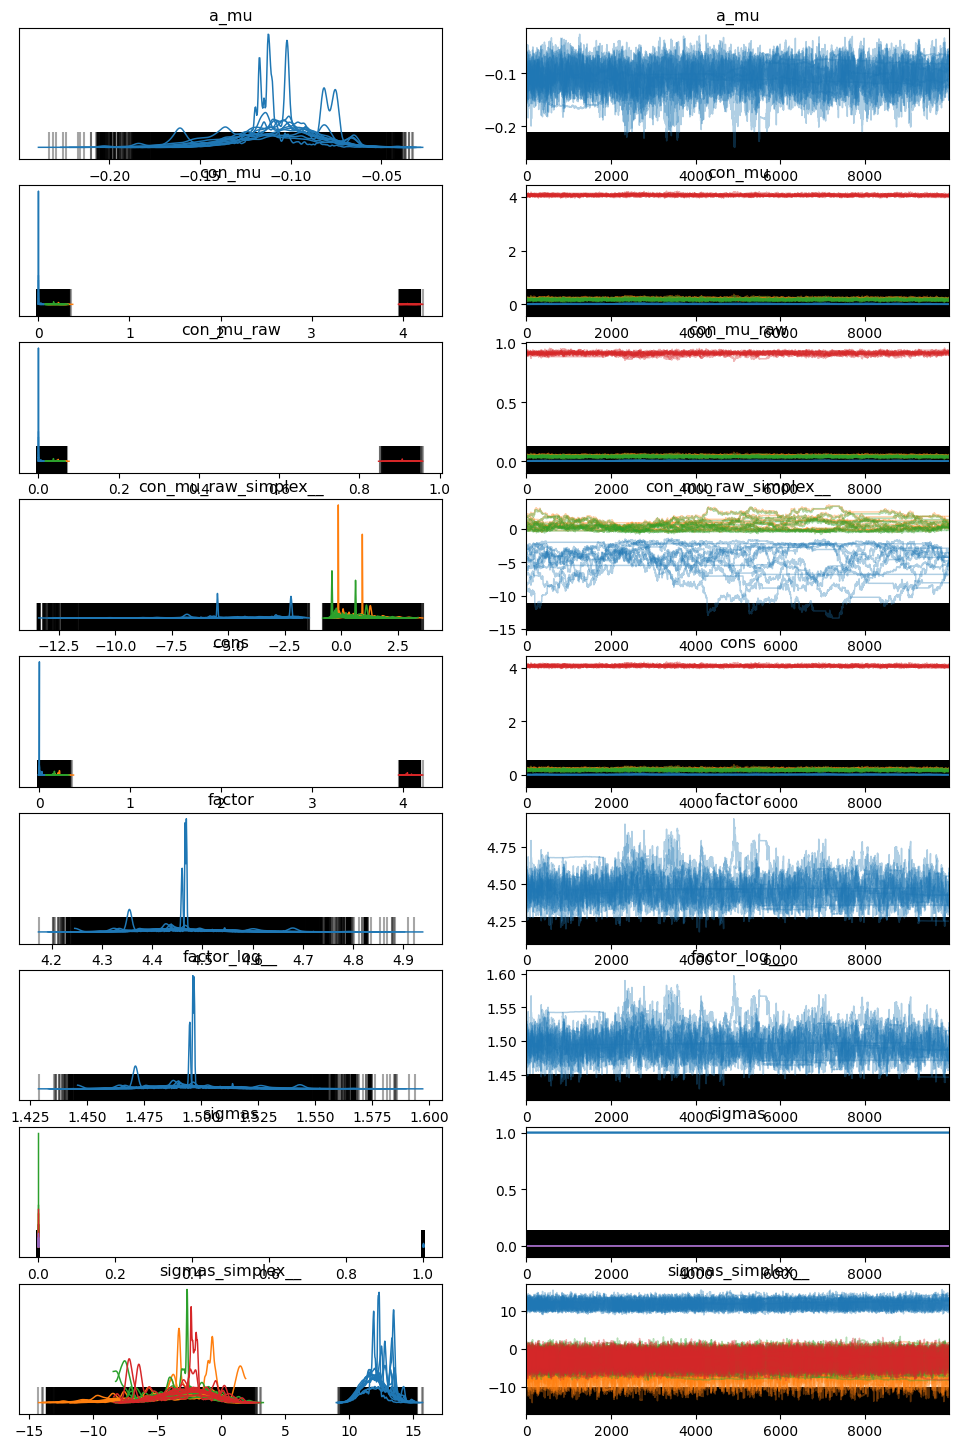

In [195]:
az.plot_trace(trace_nutpie,
              compact="true",
    chain_prop={"ls": "-"},)

# Model Selection via PPC
* see [Prior and Posterior Predictive Checks](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/posterior_predictive.html)
* maybe [BART / Bayesian additive regression trees](https://www.pymc.io/projects/bart/en/latest/examples/bart_introduction.html) can enhance the modeling

In [19]:
with model0:
    idata = pm.sample_prior_predictive(draws=50)

Sampling: [a_mu, a_sigma, con_sigmas, cons, value]


In [21]:

az.plot_ppc(idata.posterior, num_pp_samples=100);

AttributeError: 'InferenceData' object has no attribute 'posterior'

In [22]:
idata.prior

<xarray.Dataset> Size: 3kB
Dimensions:           (chain: 1, draw: 50, con_sigmas_dim_0: 2, cons_dim_0: 2)
Coordinates:
  * chain             (chain) int32 4B 0
  * draw              (draw) int32 200B 0 1 2 3 4 5 6 7 ... 43 44 45 46 47 48 49
  * con_sigmas_dim_0  (con_sigmas_dim_0) int32 8B 0 1
  * cons_dim_0        (cons_dim_0) int32 8B 0 1
Data variables:
    a_mu              (chain, draw) float64 400B -3.888 8.243 ... 1.139 10.28
    a_sigma           (chain, draw) float64 400B 0.3543 0.7871 ... 1.927 0.645
    con_sigmas        (chain, draw, con_sigmas_dim_0) float64 800B 0.8964 ......
    cons              (chain, draw, cons_dim_0) float64 800B -0.07385 ... 0.4735
Attributes:
    created_at:                 2024-09-20T05:13:44.670094+00:00
    arviz_version:              0.19.0
    inference_library:          pymc
    inference_library_version:  5.16.2